# Визуализации для того, чтобы показать идею работы

Как нейронная сеть улучшает линейный классфикатор

In [2]:
import os
import os.path as os_path
from sys import path

import numpy as np

from sklearn.linear_model import LogisticRegression

import plotly.express as px
import plotly.graph_objects as go

import torch
import torch.nn as nn
import torch.optim as optim
from torch import tensor

project_filename = 'diplom_project'
cwd = os.getcwd()
prog_path = os_path.join(
    os_path.join(
        cwd[:cwd.find(project_filename)], 
        project_filename
    ),
    'prog'
)
common_path = os_path.join(prog_path, 'common')
common_prog_path = os_path.join(common_path, 'prog')
common_data_path = os_path.join(common_path, 'data')
non_lin_data_path = os_path.join(common_data_path, 'non_lin_classy')


if prog_path not in path:
    path.append(prog_path)
    
if common_prog_path not in path:
    path.append(common_prog_path)

from DS_common import visualisations
from data_loader import load_data
from common import get_p_bar

# Логистическая регрессия

Данные, модель, предсказания и точка отсечения

In [3]:
X, y = load_data(non_lin_data_path + '.csv')
model = LogisticRegression().fit(X,y)
p_hat = model.predict_proba(X)[:, 1]
p_bar = get_p_bar(y, p_hat)
is_correct_pred = ((p_hat > p_bar).ravel() == y)
incorrect_pred = np.invert(is_correct_pred)

## Базовые настройки графики

### 2d диаграмма рассеяния

In [4]:
# настройки 2d графика
scatter_layout_settings = dict(
    height = 700,
    showlegend=False,
    xaxis_range = [0,1],
    yaxis_range = [0,1],
    margin={'l': 0, 'r': 0, 't': 0, 'b': 0}, 
)
scatter_traces_settings = dict(
    marker_size = 10
)

# y для того, чтобы на графике отображался нормально
shape_color_y = np.where(y == False, '0', np.where(y == True, '1', y))

### 3d поверхность

In [5]:
plot3d_layout = dict(
    width = 750,
    height = 750,
    scene_camera = {'eye' : {
        'x':-1.50, 'y':1.50, 'z':1.50
    }},
    legend_itemsizing = 'constant',
    legend_title_text = "",
    margin = {'l': 0, 'r': 0, 't': 0, 'b': 0}
)

p_bal_line_bord = [-0.2, 1.2]
x1 = np.linspace(p_bal_line_bord[0], p_bal_line_bord[1], 50)
x2 = np.linspace(p_bal_line_bord[0], p_bal_line_bord[1], 50)
x1, x2 = np.meshgrid(x1,x2)
sim_fun = lambda x: 1/(1+np.exp(-x))
pp = sim_fun(
    x1*model.coef_[0,0] + x2*model.coef_[0,1] + model.intercept_[0]
)
i_ind, j_ind, k_ind = visualisations.get_meshtraces(x1)

mesh_params = dict(
    x=x1.ravel(),
    y=x2.ravel(),
    z=pp.ravel(),
    opacity=0.5, color='gray',
    colorbar_thickness=25, 
    flatshading=True,
    showlegend = True,
    name = 'сигмоида',
    i = i_ind, j = j_ind, k = k_ind
)

mesh_go = go.Mesh3d(**mesh_params)

## Базовые графики

In [6]:
# общие настройки точек на графиках
common_scatter_settings = dict(
    x = X[:,0], y = X[:,1], color = shape_color_y,
    color_discrete_sequence = ['rgb(0,0,255)','rgb(255,140,0)']
)

### Диаграмма рассеяния

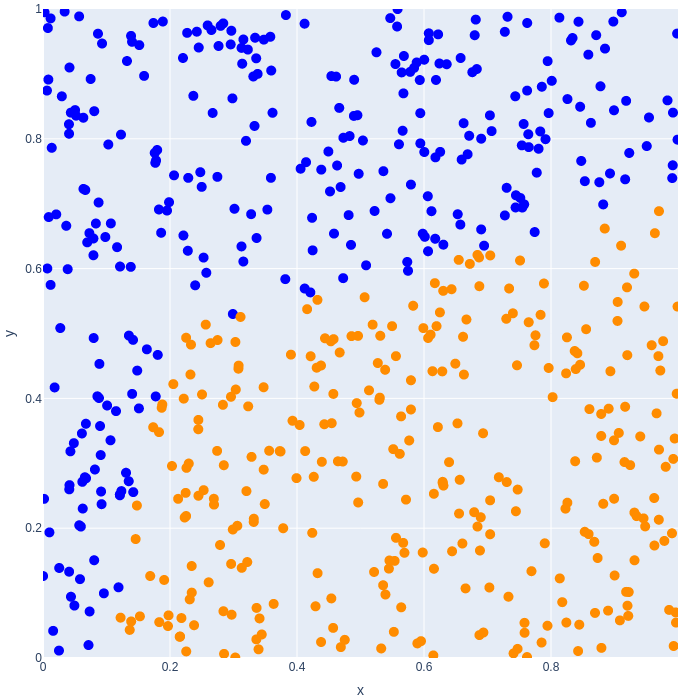

In [7]:
basic_fig = px.scatter(
    **common_scatter_settings
)

basic_fig.update_traces(**scatter_traces_settings)
basic_fig.update_layout(**scatter_layout_settings)

basic_fig.show()
basic_fig.write_image('idea_vis/basic_scatter.png')

### Добавим трехмерный график с нанесенным логитом

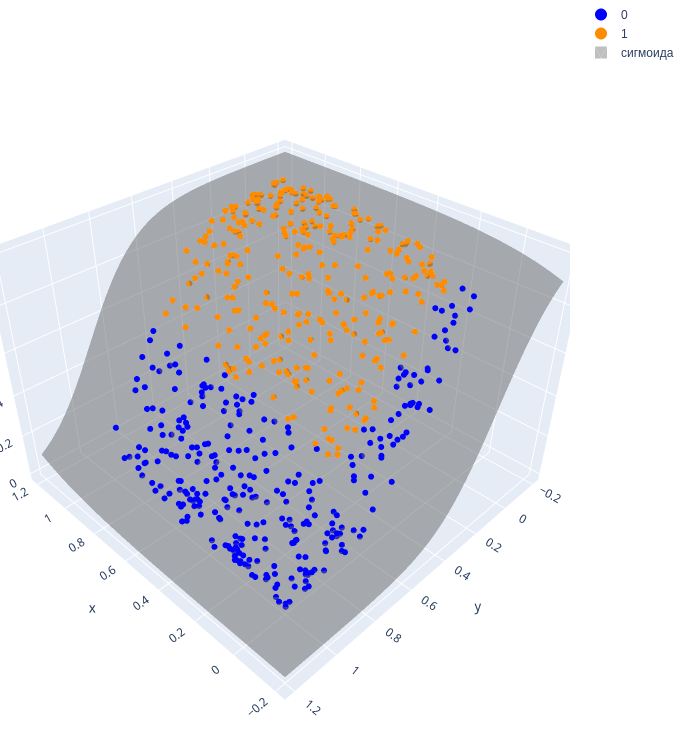

In [8]:
mesh_fig = px.scatter_3d(
    z = model.predict_proba(X)[:, 1],
    **common_scatter_settings
)

mesh_fig.update_traces(
    marker_size = 2
)

mesh_fig.update_layout(
    **plot3d_layout
)

mesh_fig.append_trace(
    mesh_go,
    row = 1,col = 1
)

mesh_fig.show()

## Теперь с точкой отсечения и предсказаниями модели

In [9]:
discr_line_x2 = lambda x1:\
    (-np.log((1 - p_bar)/p_bar)-model.intercept_[0]-x1*model.coef_[0,0])/model.coef_[0,1]

x2_1 = discr_line_x2(p_bal_line_bord[0])
x2_2 = discr_line_x2(p_bal_line_bord[1])

p_bar_line_settings = dict(
    x = p_bal_line_bord, y = [x2_1, x2_2],
    line = dict(color = 'black', width = 5)
)

### Диаграмма рассеяния

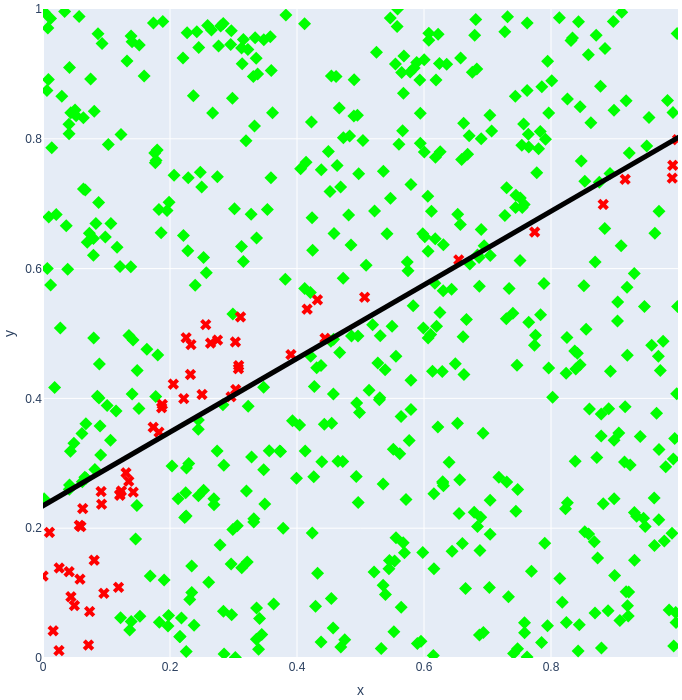

In [10]:
# в данном случае использовать общие
# настройки точек не получается
# так как для 3d графика приходиться
# создавать отдельно каждый цвет
basic_fig = px.scatter(
    x = X[:,0], y = X[:,1], 
    color = is_correct_pred,
    symbol = is_correct_pred,
    symbol_sequence = ['diamond','x'],
    color_discrete_sequence = ['rgb(0,255,0)','rgb(255,0,0)']
)
basic_fig.update_traces(**scatter_traces_settings)
basic_fig.update_layout(**scatter_layout_settings)

basic_fig.append_trace(
    go.Scatter(**p_bar_line_settings),
    col = 1, row = 1
)

basic_fig.show()
basic_fig.write_image('idea_vis/basic_scatter_pbar.png')

# Трехмерный график с логитом

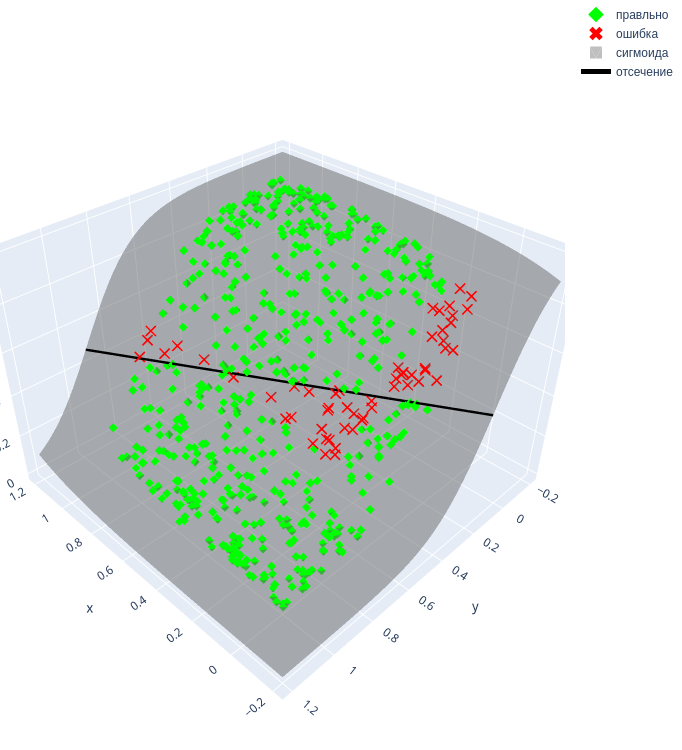

In [12]:
mesh_fig = go.Figure(
    data = [
        go.Scatter3d(
            x = X[is_correct_pred,0], 
            y = X[is_correct_pred,1], 
            z = p_hat[is_correct_pred],
            mode = 'markers',
            marker = dict(
                color = "rgb(0, 255, 0)",
                size = 3, symbol = "diamond"
            ),
            name = "правльно"
        ),
        go.Scatter3d(
            x = X[incorrect_pred,0], 
            y = X[incorrect_pred,1], 
            z = p_hat[incorrect_pred],
            mode = 'markers',
            marker = dict(
                color = "rgb(255, 0, 0)",
                size = 3, symbol = "x"
            ),
            name = "ошибка"
        ),
        mesh_go,
        go.Scatter3d(
            **p_bar_line_settings,
            z = [p_bar]*2,
            mode = 'lines',
            name = "отсечение"
        )
    ]
)

mesh_fig.update_layout(
    **plot3d_layout
)

mesh_fig.show()

# Нейронная сеть

## Обучение модели

In [11]:
X_tens = tensor(X.astype('float32'))
y_tens = tensor(y.astype('float32').reshape([len(y), 1]))

torch.manual_seed(10)

class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(2, 2)
        self.fc2 = nn.Linear(2, 1)

        self.fc1.weight = \
        nn.parameter.Parameter(tensor([[-1.8193, 4.6818], [-5.7335, 2.2301]]))
        self.fc2.weight = \
        nn.parameter.Parameter(tensor([[-3.3749, -5.6865]]))
    
    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

simple_net = SimpleNet()

optimizer = optim.Adam(simple_net.parameters(), lr=0.001)
loss_fn = torch.nn.BCELoss()

for t in range(10000):
    predict = simple_net(X_tens)
    loss = loss_fn(predict, y_tens)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## Точка отсчения и получение координат дискриминирующей линии

Для вычисления координат дискиминирующей линии задейсвован численный метод. Для того, чтобы быстро разобраться в будующем дадим тут некоторые коментарии.<br>

Далее ряд методов, которые помогяют вычислить $x_2$

In [12]:
p_hat = simple_net(X_tens).detach().numpy()
p_bar = get_p_bar(y, p_hat)
# в каждои из случаев фигурирует константа
spes_const = -np.log((1-p_bar)/p_bar)

def my_model_get_param(model):
    '''Получение параметров модели словарем'''
    # input:
    # model - модель для которой производится извл. параметров
    # output
    # словарь вида {"название параметра" : <значение праметра>}
    
    result = {}
    result['b1_1'] = model.fc1.bias[0].item()
    result['b2_1'] = model.fc1.bias[1].item()
    result['b_2'] = model.fc2.bias.item()
    result['w11_1'] = model.fc1.weight[0,0].item()
    result['w21_1'] = model.fc1.weight[1,0].item()
    result['w12_1'] = model.fc1.weight[0,1].item()
    result['w22_1'] = model.fc1.weight[1,1].item()
    result['w11_2'] = model.fc2.weight[0,0].item()
    result['w12_2'] = model.fc2.weight[0,1].item()
    
    return result

p = my_model_get_param(simple_net)

def com_x2_type1(x1, p = p, spes_const = spes_const):
    '''Вычисление x2 для того случая, если z1 > 0 а z2 <= 0'''
    return ((spes_const - p['b_2'])/p['w11_2'] - x1*p['w11_1'] - p['b1_1'])/\
            p['w12_1']

def com_x2_type2(x1, p = p, spes_const = spes_const):
    '''Вычсление x2 для того случая, если z2 > 0 a z1 <= 0'''
    
    return ((spes_const - p['b_2'])/p['w12_2'] - x1*p['w21_1'] - p['b2_1'])/\
                                    p['w22_1']


def com_x2_type3(x1, p = p, spes_const = spes_const):
    '''Вычисление x2 для того случая, если z2 > 0 и z1 > 0'''
    
    return (spes_const - x1*(p['w11_1']*p['w11_2'] + p['w21_1']*p['w12_2']) -\
            p['b1_1']*p['w11_2'] - p['b2_1']*p['w12_2'] - p['b_2'])/\
                (p['w12_1']*p['w11_2'] + p['w22_1']*p['w12_2'])

def compute_x2(x1, model, spes_const = spes_const):
    '''
    Вычисление x2. Вызов предыдущих двух функций
    и определение какой результат подходит для данного x1
    '''
    
    p = my_model_get_param(model)
    
    # пробуем первый тип
    x2 = com_x2_type1(x1, p, spes_const)
    is_sum_more0 = model.fc1(tensor([x1, x2]).to(torch.float32)) > 0
    if all(is_sum_more0 == tensor([True, False])):
        return x2
    
    # пробуем втрой тип
    x2 = com_x2_type2(x1, p, spes_const)
    is_sum_more0 = model.fc1(tensor([x1, x2]).to(torch.float32)) > 0
    if all(is_sum_more0 == tensor([False, True])):
        return x2
    
    # пробуем третий тип
    x2 = com_x2_type3(x1, p, spes_const)
    is_sum_more0 = model.fc1(tensor([x1, x2]).to(torch.float32)) > 0
    if all(is_sum_more0 == tensor([True, True])):
        return x2
    
    # если ни один из вариантов не сработал - генерируем ошибку
    raise ArithmeticError('Ни один из варинтов не был задейсвован')

Проверка - при подстановке в нейронную сеть выбранного $x_1$ и вычисленного $x_2$ должно получаться значение $p'$. Допускаю некоторую погрешность подому сравниваю визуально

In [13]:
x1 = 0.5
x2 = compute_x2(x1, simple_net)

print("дейсвительный p'", p_bar)
print(
    'значение при подстановке в нейронную сеть',
    simple_net(tensor([x1, x2]).to(torch.float32)).item()
)

дейсвительный p' 0.5858726
значение при подстановке в нейронную сеть 0.585873007774353


Вычисление массивов $x_1$ и $x_2$ таких, чтобы при подстанвоке в нейронную сеть давали $p'$. Это и будет множество координат дискриминирующей кривой.

In [14]:
x1 = np.linspace(p_bal_line_bord[0], p_bal_line_bord[1], 50)
x2 = np.fromiter(
        map(lambda x1: compute_x2(x1, simple_net), x1), np.float32
)

## Диаграмма рассеяния

К базовой диаграмме рассеяния добавляем отсечение полученное по нейронной сети

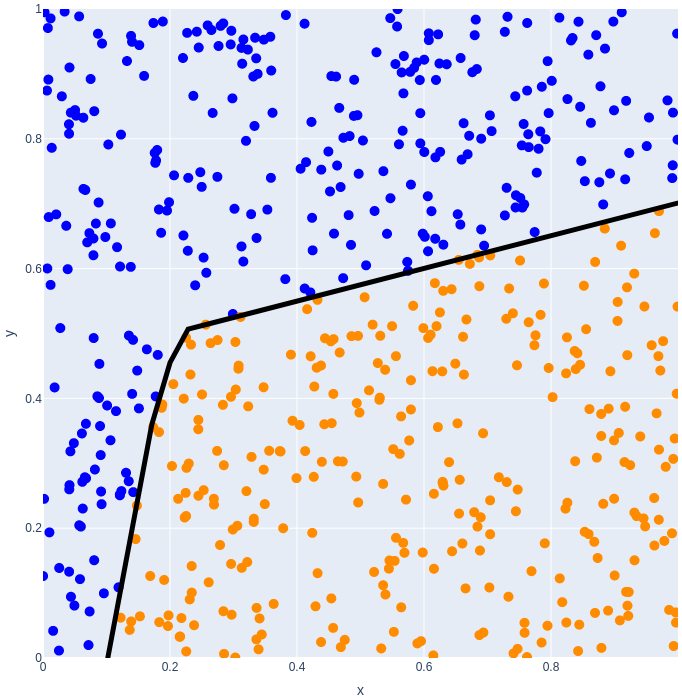

In [15]:
basic_fig = px.scatter(
    **common_scatter_settings
)

basic_fig.update_traces(**scatter_traces_settings)
basic_fig.update_layout(**scatter_layout_settings)

p_bar_line_settings = dict(
    x = x1, y = x2,
    mode = 'lines', name = "отсечение",
    line = dict(color = 'black', width = 5)
)

basic_fig.append_trace(
    go.Scatter(
        **p_bar_line_settings
    ),
    col = 1, row = 1
)

basic_fig.write_image('idea_vis/non_linear_scatter.png')
basic_fig.show()

## Трехмерный график с логитом

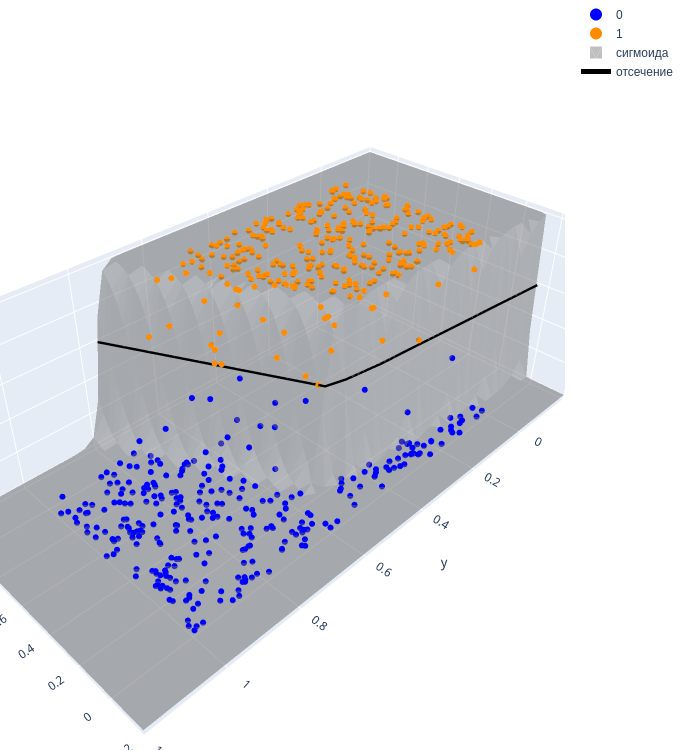

In [16]:
mesh_fig = px.scatter_3d(
    z = p_hat[:, 0],
    **common_scatter_settings
)

mesh_fig.update_traces(
    marker_size = 2
)


# подчитаем и запишем в настройки гарфики данные новой модели
pp = simple_net(tensor(np.concatenate([
    np.array(mesh_params['x']).reshape([len(mesh_params['x']), 1]),
    np.array(mesh_params['y']).reshape([len(mesh_params['y']), 1])
], axis = 1)).to(torch.float32)).detach().numpy()
mesh_params['z'] = pp.ravel()

mesh_fig.append_trace(
    go.Mesh3d(**mesh_params),
    row = 1, col = 1
)

mesh_fig.append_trace(
    go.Scatter3d(
        **p_bar_line_settings,
        z = np.ones(len(x2)) * p_bar,
    ),
    row = 1, col = 1
)

mesh_fig.update_layout(
    **plot3d_layout,
    scene = dict(
        xaxis = dict(range = [-0.2,1.2]),
        yaxis = dict(range = [-0.2,1.2])
    )
)

mesh_fig.show()